# Lane Detection

Experiment with lane detection (own lane, lane to left if any)

https://www.youtube.com/playlist?list=PLS1QulWo1RIa7D1O6skqDQ-JZ1GGHKK-K

https://www.youtube.com/watch?v=yvfI4p6Wyvk

https://medium.com/analytics-vidhya/building-a-lane-detection-system-f7a727c6694

https://github.com/Arun-purakkatt/medium_repo/blob/main/road_lane_detection%20(1).py


## Configuration

In [1]:
sample_image_filename = 'sample_dashcam_lanes1.png'
#sample_image_filename = 'evil.png'

# Parameters for predicting lane width
model_name              = 'distance'
width_prediction_height = 640 # Chosen to be just in front of the bonnet of the car

frame_width  = 1920
frame_height = 1080

mask_vertices = [
    (0, 640),
    (frame_width/2, 375),
    (frame_width, 640)
]

own_lane_vertices = [
    (500, 640),
    (int(frame_width/2), 400),
    (frame_width-500, 640)
]

left_lane_mask_top    = 375
left_lane_mask_bottom = 690
left_lane_mask_margin = 80

min_slope = 0.30
max_slope = 0

## Initialise

In [2]:
import os
import sys
from pathlib import Path

import cv2
import numpy as np


# Make sure local modules can be imported
module_path_root = os.path.abspath(os.pardir)
if module_path_root not in sys.path:
    sys.path.append(module_path_root)
    
# Import local modules
import cv_utils.lane_detection as lane_detection

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Derive paths
calibration_config = os.path.join(module_path_root, 'data_sources', 'dashcam_calibration.yml')
sample_image_path  = os.path.join(module_path_root, 'data_sources', sample_image_filename)
model_dir          = os.path.join(module_path_root, 'models')

In [4]:
ld = lane_detection(calibration_config=calibration_config, model_dir=model_dir, width_estimation_model=model_name)

## Demo 1: Simple Correct/Canny/Crop/Hough sequence

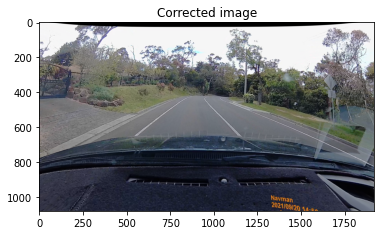

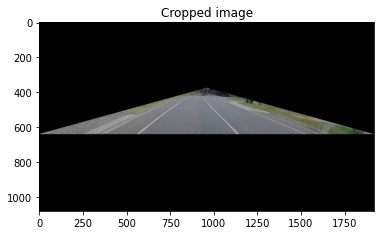

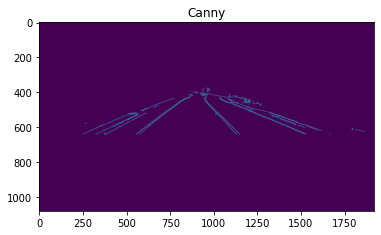

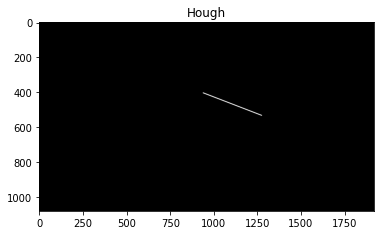

In [5]:
# Load original image
corrected_image = ld.load_image(sample_image_path)
cropped_image   = ld.apply_mask(corrected_image, mask_vertices=mask_vertices)
canny_image     = ld.apply_canny(corrected_image, mask_vertices=mask_vertices)
hough_image     = ld.apply_hough(canny_image, color=(255,255,255))

plt.imshow(corrected_image)
plt.title('Corrected image')
plt.show()

plt.imshow(cropped_image)
plt.title('Cropped image')
plt.show()

plt.imshow(canny_image)
plt.title('Canny')
plt.show()

plt.imshow(hough_image)
plt.title('Hough')
plt.show()

## Demo 2: Draw our own lanes

https://medium.com/analytics-vidhya/building-a-lane-detection-system-f7a727c6694

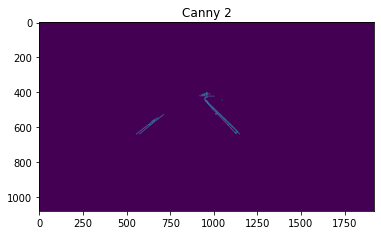

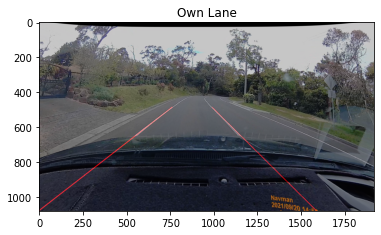

In [6]:
canny_image2 = ld.apply_canny(
    corrected_image,
    mask_vertices    = own_lane_vertices,
    Canny_threshold1 = 50,
    Canny_threshold2 = 150
)

plt.imshow(canny_image2)
plt.title('Canny 2')
plt.show()

lines = cv2.HoughLinesP(canny_image2, 2, np.pi/60, 100, np.array([]), minLineLength=10, maxLineGap=50)

left_line1, right_line1, left_slope1, left_int1, right_slope1, right_int1 = ld.find_average_lines(
    corrected_image, lines, height_limit=9/20,
    min_slope=min_slope, max_slope=max_slope
)

red_lines = [left_line1, right_line1]
red_line_image   = ld.draw_lines(cropped_image, red_lines, color=(255, 0, 0))

# Overlay the lines onto the original image
lanes_image = cv2.addWeighted(corrected_image, 0.8, red_line_image, 1, 1)

plt.imshow(lanes_image)
plt.title('Own Lane')
plt.show()


# Second pass to find the next lane over

Move the area of interest further to the left.  How far?  To the left of the left lane already identified

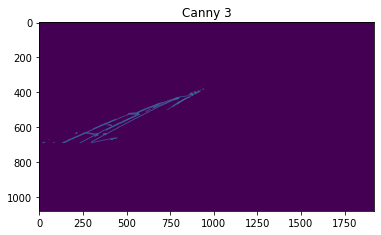

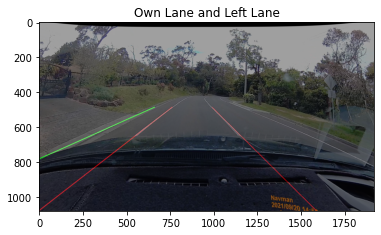

In [7]:
# Only do this if we found both a left and a right lane marking in the first pass
if left_slope1 is not None:
    left_region = [
        (0, left_lane_mask_bottom), 
        (int(frame_width/2), left_lane_mask_top), 
        (int(round((left_lane_mask_bottom - left_int1 + left_lane_mask_margin) / left_slope1)), left_lane_mask_bottom)
    ]


    canny_image3 = ld.apply_canny(
        corrected_image,
        mask_vertices    = left_region,
        Canny_threshold1 = 50,
        Canny_threshold2 = 150
    )

    plt.imshow(canny_image3)
    plt.title('Canny 3')
    plt.show()
 
    lines = cv2.HoughLinesP(canny_image3, 2, np.pi/60, 100, np.array([]), minLineLength=10, maxLineGap=100)

    left_line2, right_line2, left_slope2, left_int2, right_slope2, right_int2 = ld.find_average_lines(
        corrected_image, lines, height_limit=9/20,
        min_slope=min_slope, max_slope=max_slope
    )

    green_line       = [left_line2]
    green_line_image = ld.draw_lines(cropped_image, green_line, color=(0, 255, 0))

    # Overlay the lines onto the original image
    lanes_image2 = cv2.addWeighted(corrected_image, 0.8, red_line_image,   1, 1)
    lanes_image2 = cv2.addWeighted(lanes_image,     0.8, green_line_image, 1, 1)

    plt.imshow(lanes_image2)
    plt.title('Own Lane and Left Lane')
    plt.show()

## Demo 3: All in one

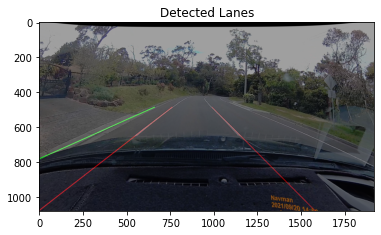

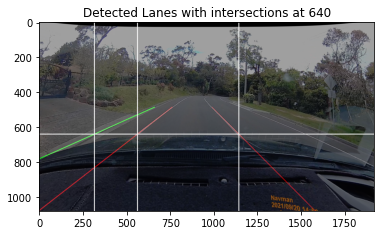

Pixel width of left lane at  640: 246.87
Estimated left lane width at 640: 143.69


In [8]:
detected_lanes_image, slopes_and_intercepts = ld.detect_lanes(
    corrected_image,
    own_lane_vertices,
    left_lane_mask_top    = left_lane_mask_top,
    left_lane_mask_bottom = left_lane_mask_bottom,
    left_lane_mask_margin = left_lane_mask_margin,
    min_slope             = min_slope,
    max_slope             = max_slope
)

plt.imshow(detected_lanes_image)
plt.title('Detected Lanes')
plt.show()

intersection_height = 640

grid_image, intersection_list = ld.draw_intersection_grid(detected_lanes_image, slopes_and_intercepts, intersection_height)

plt.imshow(grid_image)
plt.title('Detected Lanes with intersections at {0:d}'.format(intersection_height))
plt.show()

print('Pixel width of left lane at  {0:d}: {1:.2f}'.format(
    intersection_height, ld.pixel_width(intersection_list[0], intersection_list[1])
))
      
left_lane_width = ld.predict_width(detected_lanes_image, intersection_list[0], intersection_list[1])
print('Estimated left lane width at {0:d}: {1:.2f}'.format(intersection_height, left_lane_width))